In [95]:
# for loading/processing the images
import shutil

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from keras.src.applications import VGG19, ResNet152V2, ResNet50
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [96]:
path_summary = f'C:/Users/Anders/OneDrive - USN/IIA/Semester 4 - Master Thesis/ProjectFiles/CWTCluster/Zsummary_7.csv'

N_CLASSES = 7

SEQUENCE_LENGTH = 120
PCA_COMPONENTS = 10

DATA_SETS = ["normal_data",  "friction_data", "vibration_data", "rampupdown_data", "vibration_low_data", "friction_low_data"] # "normal_data",
DATA_SETS_F = []
for val in DATA_SETS:
    if val == "rampupdown_data":
        DATA_SETS_F.append("rampUp_data")
        DATA_SETS_F.append("rampDown_data")
    else:
        DATA_SETS_F.append(val)

#Create result PATH
name = "CWT_CLUSTERING_"
name += str(N_CLASSES) + "_"
for datasets in DATA_SETS:
    name += datasets + "_"
name += "seqLen" + str(SEQUENCE_LENGTH) + "_" + "PCA" +  str(PCA_COMPONENTS) + "_"
RESULT_PATH = "Results/CWT - Clustering/" + name
SEQUENCE_NAME = "SEQUENCES_"+ name +".pkl"

# read csv to dataframe
df = pd.read_csv(path_summary)

df





,Unnamed: 0,File,Class
0,0,Friction_0.png,4
1,1,Friction_10.png,4
2,2,Friction_103.png,4
3,3,Friction_105.png,4
4,4,Friction_109.png,4
...,...,...,...
1395,1395,Vibration_low_977.png,0
1396,1396,Vibration_low_980.png,0
1397,1397,Vibration_low_986.png,5
1398,1398,Vibration_low_990.png,5


In [97]:
def countUniquesByClass(df, class_name, N_CLASSES):

    df = df[df['File'].str.startswith(class_name)]
    counts = [0 for i in range(N_CLASSES)]
    counts_str = [str(i) for i in range(N_CLASSES)]
    # Create a hashmap with counts_str and counts
    counts_dict = dict(zip(counts_str, counts))
    
    
    for values in df['Class'].values:
        counts_dict[str(values)] += 1

    return counts_dict

Friction_map = (countUniquesByClass(df, 'Friction', N_CLASSES))
Vibration_map = (countUniquesByClass(df, 'Vibration', N_CLASSES))

print(Friction_map)
print(Vibration_map)

{'0': 118, '1': 0, '2': 0, '3': 0, '4': 197, '5': 85, '6': 0}
{'0': 107, '1': 0, '2': 0, '3': 200, '4': 0, '5': 93, '6': 0}


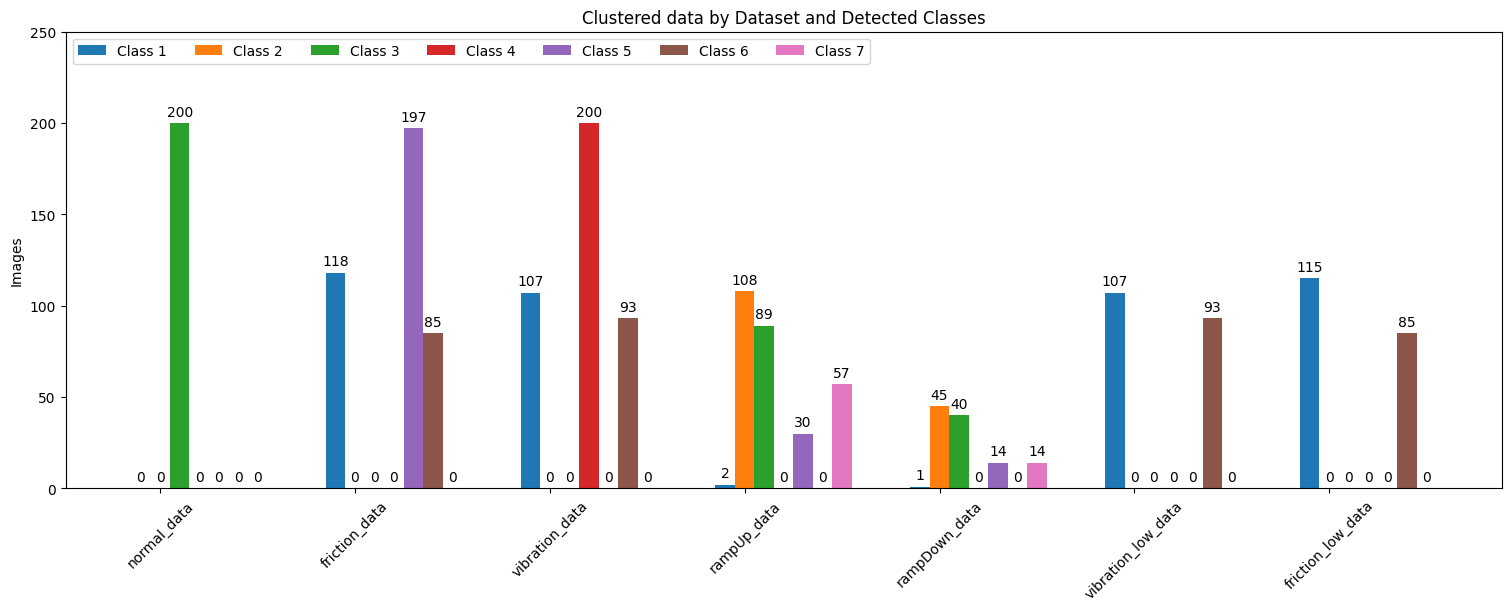

In [98]:


Normal_map = (countUniquesByClass(df, 'Normal', N_CLASSES))
Friction_map = (countUniquesByClass(df, 'Friction', N_CLASSES))
Vibration_map = (countUniquesByClass(df, 'Vibration', N_CLASSES))
RampUp_map = (countUniquesByClass(df, 'RampUp', N_CLASSES))
RampDown_map = (countUniquesByClass(df, 'RampDown', N_CLASSES))
Vibration_low_map = (countUniquesByClass(df, 'Vibration_low', N_CLASSES))
Friction_low_map = (countUniquesByClass(df, 'Friction_low', N_CLASSES))



detected_classes = {
    'Class 1' : (Normal_map['0'], Friction_map['0'], Vibration_map['0'], RampUp_map['0'], RampDown_map['0'], Vibration_low_map['0'], Friction_low_map['0']),
    'Class 2' : (Normal_map['1'], Friction_map['1'], Vibration_map['1'], RampUp_map['1'], RampDown_map['1'], Vibration_low_map['1'], Friction_low_map['1']),
    'Class 3' : (Normal_map['2'], Friction_map['2'], Vibration_map['2'], RampUp_map['2'], RampDown_map['2'], Vibration_low_map['2'], Friction_low_map['2']),
    'Class 4' : (Normal_map['3'], Friction_map['3'], Vibration_map['3'], RampUp_map['3'], RampDown_map['3'], Vibration_low_map['3'], Friction_low_map['3']),
    'Class 5' : (Normal_map['4'], Friction_map['4'], Vibration_map['4'], RampUp_map['4'], RampDown_map['4'], Vibration_low_map['4'], Friction_low_map['4']),
    'Class 6' : (Normal_map['5'], Friction_map['5'], Vibration_map['5'], RampUp_map['5'], RampDown_map['5'], Vibration_low_map['5'], Friction_low_map['5']),
    'Class 7' : (Normal_map['6'], Friction_map['6'], Vibration_map['6'], RampUp_map['6'], RampDown_map['6'], Vibration_low_map['6'], Friction_low_map['6']),

    # 'Class 1' : (Normal_map['0'], Friction_low_map['0'], Vibration_low_map['0']),
    # 'Class 2' : (Normal_map['1'], Friction_low_map['1'], Vibration_low_map['1']),
    # 'Class 3' : (Normal_map['2'], Friction_low_map['2'], Vibration_low_map['2']),
}

x = np.arange(len(DATA_SETS_F))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in detected_classes.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images')
ax.set_title('Clustered data by Dataset and Detected Classes')
ax.set_xticks(x + width, DATA_SETS_F)
plt.xticks(rotation=45)
ax.legend(loc='upper left', ncols=N_CLASSES)
ax.figure.set_size_inches(15, 6)
ax.set_ylim(0, 250)
plt.savefig(RESULT_PATH + "GRAPH.png")
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt

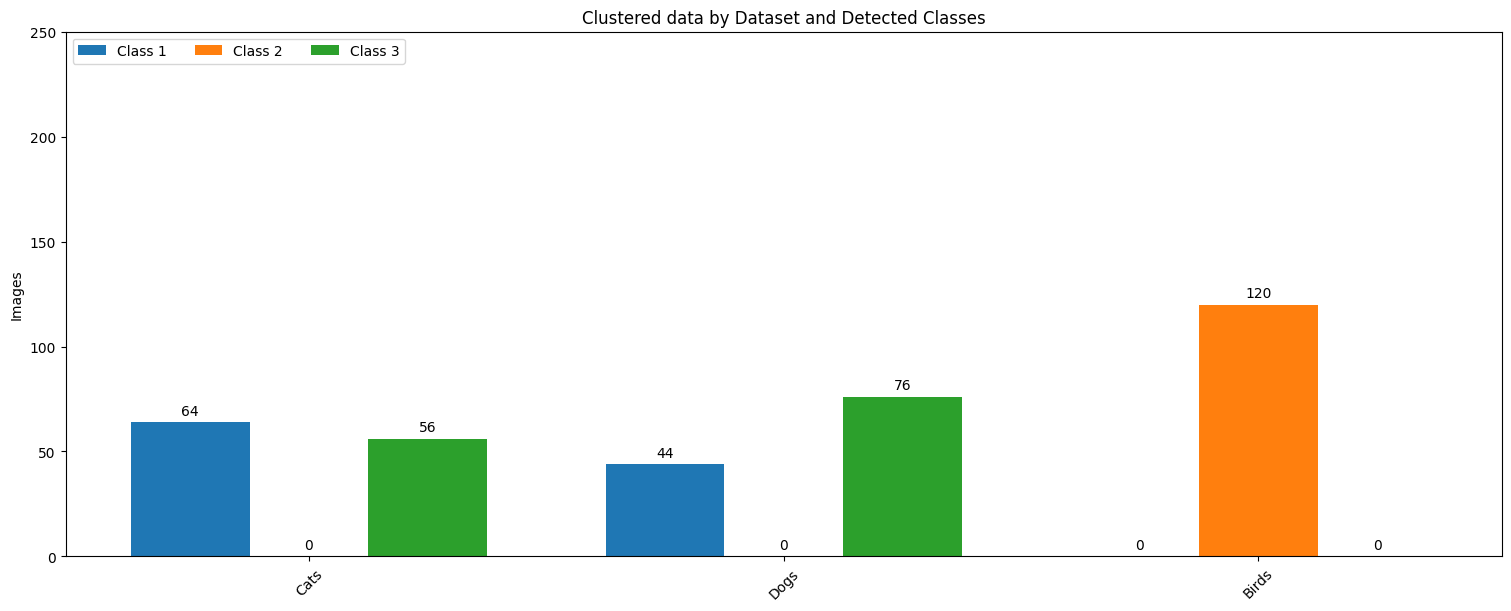

In [21]:

ind = ['0', '1', '2']
#Crate a map looking like this {'0': 120, '1': 0, '2': 0}

Gen1 = dict(zip(ind,[64,0,56]))
Gen2 = dict(zip(ind,[44,0,76]))
Gen3 = dict(zip(ind,[0,120,0]))


GenNames = ['Cats', 'Dogs', 'Birds']

detected_classes = {
    'Class 1' : (Gen1['0'], Gen2['0'], Gen3['0']),
    'Class 2' : (Gen1['1'], Gen2['1'], Gen3['1']),
    'Class 3' : (Gen1['2'], Gen2['2'], Gen3['2']),

    # 'Class 1' : (Normal_map['0'], Friction_low_map['0'], Vibration_low_map['0']),
    # 'Class 2' : (Normal_map['1'], Friction_low_map['1'], Vibration_low_map['1']),
    # 'Class 3' : (Normal_map['2'], Friction_low_map['2'], Vibration_low_map['2']),
}

x = np.arange(3)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in detected_classes.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images')
ax.set_title('Clustered data by Dataset and Detected Classes')
ax.set_xticks(x + width, GenNames)
plt.xticks(rotation=45)
ax.legend(loc='upper left', ncols=3)
ax.figure.set_size_inches(15, 6)
ax.set_ylim(0, 250)
#plt.savefig(RESULT_PATH + "GRAPH.png")
plt.show()